# Performance optimization exercise 2

Optimize the following function.

In [20]:
function work!(A, B, v, N)
    val = 0
    for i in 1:N
        for j in 1:N
            val = mod(v[i],256);
            A[i,j] = B[i,j]*(sin(val)*sin(val)-cos(val)*cos(val));
        end
    end
    return A
end

work! (generic function with 1 method)

The (fixed) input is given by:

In [30]:
N = 4000
A = [float(i+j) for i in 1:N, j in 1:N] # matrix of size NxN
B = [float(i-j) for i in 1:N, j in 1:N]
v = [i for i in 1:N]

work!(A,B,v,N);

You can benchmark with the following code snippet. The **larger** the Mega-iterations per second (MIt/s) the better!

In [22]:
using BenchmarkTools
runtime = @belapsed work!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 20.60253875813974 MIt/s


## Optimizations

### Analytic optimization

In [23]:
using Test
x = rand()
@test 1-2*cos(x)*cos(x) ≈ sin(x)*sin(x)-cos(x)*cos(x)
@test -cos(2*x) ≈ sin(x)*sin(x)-cos(x)*cos(x)

Test Passed

In [24]:
function work2!(A, B, v, N)
    val = 0
    for i in 1:N
        for j in 1:N
            val = mod(v[i],256);
            A[i,j] = B[i,j]*(-cos(2*val));
        end
    end
end

runtime = @belapsed work2!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 49.10364789404336 MIt/s


### Analytic + pulling out val computation

In [25]:
function work3!(A, B, v, N)
    val = 0.0
    for i in 1:N
        val = -cos(2*mod(v[i],256))
        for j in 1:N
            A[i,j] = B[i,j]*val;
        end
    end;
end

runtime = @belapsed work3!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 68.96434128045644 MIt/s


### Analytic + separate out val computation

In [26]:
function work4!(A, B, v, N)
    val = [-cos(2*mod(x,256)) for x in v]
    
    for i in 1:N
        for j in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work4!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 73.16781915966202 MIt/s


### Analytic + separate out val computation + switch order of loops

In [27]:
function work5!(A, B, v, N)
    val = [-cos(2*mod(x,256)) for x in v]
    
    for j in 1:N
        for i in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work5!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 789.8467179030359 MIt/s


### Analytic + separate out val computation + switch order of loops + `@inbounds`

In [28]:
function work6!(A, B, v, N)
    val = [-cos(2*mod(x,256)) for x in v]
    
    @inbounds for j in 1:N
        for i in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work6!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1056.0589766696112 MIt/s


### Analytic + separate out val computation + switch order of loops + `@inbounds` + lookup table

In [29]:
lookup = [ -cos(2*j) for j in 0:255 ]

function work7!(A, B, v, N, lookup)
    @inbounds val = [lookup[mod(x,256)+1] for x in v]
    
    @inbounds for j in 1:N
        for i in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work7!($A, $B, $v, $N, $lookup);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1081.478670638307 MIt/s


### Analytic + separate out val computation + switch order of loops + `@inbounds` + Multi-threading

In [40]:
using Hwloc
Hwloc.num_physical_cores()

6

In [41]:
Base.Threads.nthreads()

6

In [48]:
import Base.Threads: @threads

function work6_threaded!(A, B, v, N)
    val = [-cos(2*mod(x,256)) for x in v]
    
    @inbounds @threads for j in 1:N
        for i in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work6_threaded!($A, $B, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1226.2168535382832 MIt/s


In [49]:
import Base.Threads: @threads

lookup = [ -cos(2*j) for j in 0:255 ]

function work7_threaded!(A, B, v, N, lookup)
    @inbounds val = [lookup[mod(x,256)+1] for x in v]
    
    @inbounds @threads for j in 1:N
        for i in 1:N
            A[i,j] = B[i,j]*val[i];
        end
    end;
end

runtime = @belapsed work7_threaded!($A, $B, $v, $N, $lookup);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1233.7951608548874 MIt/s


## Supplement: Maximal performance?

In [50]:
bs = 32 # [GB/s] max memory bandwidth (estimated from STREAM benchmark, 41 GB/s is the Intel value for my CPU)
flops = 1
traffic = 24 # [B/iter] in each iteration we have: LOAD s, LOAD + STORE mat, each contributing 8 B
I = flops / traffic
println("Memory bounded performance: ", round(I*bs*1000, digits=2), "MIt/s")

Memory bounded performance: 1333.33MIt/s


#### "Roofline model"

In [53]:
using CpuId
clock = cpu_max_frequency() * 1e-3 # [GHz], turbo clock frequency

fma_per_cycle = 2

flops_per_fma = 4*2 # AVX2, 32 byte registers, 4 mul 4 add

flops_per_cycle = flops_per_fma * fma_per_cycle

ncores = cpucores() # used cores

P_peak = clock * flops_per_cycle * ncores # Gflops/s

432.0

Test realistic peak performance using `peakflops`, which is based on [LinearAlgebra.BLAS.gemm!](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.BLAS.gemm!), i.e. `C[i] = α*A[i]*B[i]+βC[i]`.

In [26]:
# using LinearAlgebra
# using Statistics
# BLAS.set_num_threads(6)
# p = [peakflops(Int(i*1e3)) * 1e-9 for i in 1:12]
# mean(p[end-2:end])

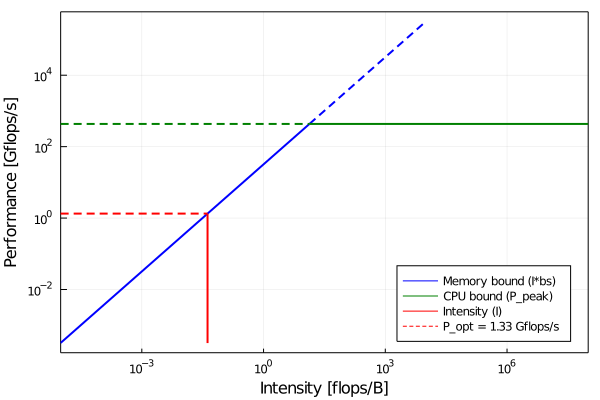

In [54]:
using Plots
# memory bound
plot(x->bs*x, label="Memory bound (I*bs)", frame=:box, color=:blue, xlim=(1e-5,P_peak/bs), lw=2, xscale=:log10, yscale=:log10, legend=:bottomright)
plot!(x->bs*x, label="", frame=:box, color=:blue, xlim=(P_peak/bs,1e4), linestyle=:dash, lw=2)

# cpu bound
plot!([P_peak / bs,1e8],[P_peak, P_peak], label="CPU bound (P_peak)", color=:green, lw=2)
plot!([1e-5,P_peak / bs],[P_peak, P_peak], label="", color=:green, lw=2, ls=:dash)

# intensity (our vecmul!)
plot!([I,I],[10^(-3.5),I*bs], label="Intensity (I)", color=:red, lw=2)
# vline!([I], label="Intensity (I)", color=:red, lw=2)

# max memory bound performance
plot!([1e-5,I],[I*bs,I*bs], label="P_opt = $(round(I*bs, digits=2)) Gflops/s", color=:red, lw=2, ls=:dash)

# ylims!(0,400)
xlims!(1e-5,1e8)
xlabel!("Intensity [flops/B]")
ylabel!("Performance [Gflops/s]")

According to expectation, our kernel computation is clearly memory bound.

In [55]:
# ratio
perf*1e-3/(I*bs)

0.9253463706411655

Our best code above almost reaches the memory bound estimate.